## All the imports

In [1]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
!pip install tensorflow_hub


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

2023-12-01 11:48:21.572644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

In [5]:
# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

## Loading the model

In [49]:
model_name = "movenet_lightning"

if "tflite" in model_name:
    if "movenet_lightning_f16" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
        input_size = 192
    elif "movenet_thunder_f16" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
        input_size = 256
    elif "movenet_lightning_int8" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
        input_size = 192
    elif "movenet_thunder_int8" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
        input_size = 256
    else:
        raise ValueError("Unsupported model name: %s" % model_name)
        
        
        
        
    input_size = 192
    
    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_path='model.tflite')
    interpreter.allocate_tensors()
    def movenet(input_image):
        """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
        """
        interpreter = tf.lite.Interpreter(model_path='model.tflite')
        interpreter.allocate_tensors()
        # TF Lite format expects tensor type of uint8.
        input_image = tf.cast(input_image, dtype=tf.uint8)
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
        # Invoke inference.
        interpreter.invoke()
        # Get the model prediction.
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
        return keypoints_with_scores
    
else:
    if "movenet_lightning" in model_name:
        module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
        input_size = 192
    elif "movenet_thunder" in model_name:
        module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
        input_size = 256
    else:
        raise ValueError("Unsupported model name: %s" % model_name)

    def movenet(input_image):
        """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
        model = module.signatures['serving_default']

        # SavedModel format expects tensor type of int32.
        input_image = tf.cast(input_image, dtype=tf.int32)
        # Run model inference.
        outputs = model(input_image)
        # Output is a [1, 1, 17, 3] tensor.
        keypoints_with_scores = outputs['output_0'].numpy()
        return keypoints_with_scores

## Inputing an image

In [50]:
image_path = "/Users/abou48862/code/kvkirya/pt-ai/raw_data/images_to_crop_00/00000008.rgb.png"

In [51]:
image = tf.io.read_file(image_path)

In [52]:
image = tf.image.decode_jpeg(image)


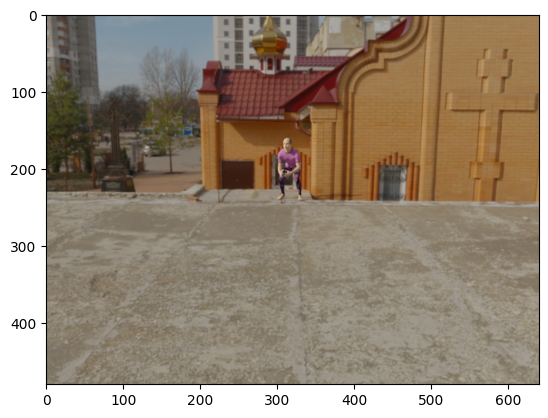

In [53]:
plt.imshow(image)

## We run the inference

In [44]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
#input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

In [54]:
img = tf.image.resize_with_pad(np.expand_dims(image, axis=0), 192,192)

In [55]:
img

<tf.Tensor: shape=(1, 192, 192, 4), dtype=float32, numpy=
array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0

In [45]:
input_image

<tf.Tensor: shape=(1, 192, 192, 4), dtype=float32, numpy=
array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0

In [48]:
# Run model inference.
keypoints_with_scores = movenet(input_image)

2023-12-01 11:56:48.279322: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at conv_ops_fused_impl.h:720 : INVALID_ARGUMENT: input depth must be evenly divisible by filter depth: 4 vs 3


InvalidArgumentError: Graph execution error:

input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1_relu/Relu6}}]] [Op:__inference_signature_wrapper_105716]